# A deeper look on Expectation Propagation
_____

In [54]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

In [55]:
def clutter_problem_data(n_samples, theta, theta_var, c_mean, c_var, c_prop=0.5):
    # sample xs
    xs = theta + np.sqrt(theta_var) * np.random.randn(n_samples, 1)
    # sample clutter
    clutter = c_mean + np.sqrt(c_var) * np.random.randn(n_samples, 1)

    # get the proportions based on the mixture coefficient
    selection = np.random.rand(n_samples, 1) > c_prop

    # sample observations
    observations = (1 - selection) * np.array(xs) + selection * np.array(clutter)
    return observations

In [56]:
def plot_clutter(obs, theta, theta_var, c_mean, c_var, c_prop, appx=None,graph_offset=0):
    # draw support
    xs = np.linspace(np.min(obs) - graph_offset, np.max(obs) + graph_offset, 1000)
    xs = np.linspace(0, 20, 1000)

    # draw densities
    c1 = norm.pdf(xs, loc=theta, scale=np.sqrt(theta_var))
    c2 = norm.pdf(xs, loc=c_mean, scale=np.sqrt(c_var))
    mix = (1 - c_prop) * c1 + c_prop * c2

    # plot
    plt.plot(xs, c1, "g--", linewidth=2, label="signal")
    plt.plot(xs, c2, "b--", linewidth=2, label="clutter")
    plt.plot(xs, mix, "r", linewidth=2, label="obs distribution")
    if appx is not None:
        for method, density in appx.items():
            plt.plot(xs, [density(x) for x in xs], linewidth=2, label=f'{method} approximation')
    plt.scatter(obs, 0.05 * np.ones_like(obs), marker="+", label="samples")

    plt.legend(loc="best")

    plt.show()

In [57]:
theta = 5
theta_var = 1
c_var = 5
c_mean = 15
c_prop = 0.5
n_samples = 20

ys = clutter_problem_data(
    n_samples=n_samples,
    theta=theta,
    theta_var=theta_var,
    c_var=c_var,
    c_mean=c_mean,
    c_prop=c_prop,
)


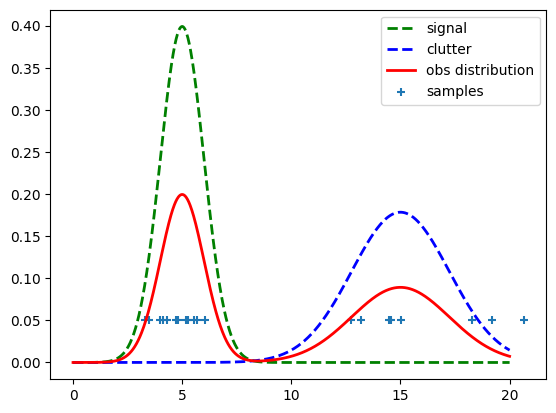

In [58]:
plot_clutter(ys, theta, theta_var, c_mean, c_var, c_prop=0.5, graph_offset=5)

## Running the approximation

In [62]:
def ep_approximate(ys, n_iter, prior_theta, prior_theta_var, theta_var, c_mean, c_var):
    # init messages from observation to factor variable
    mean_factor_to_variable = np.zeros_like(ys)
    var_factor_to_variable = 1e16 * np.ones_like(ys)  # large variance

    x_samples = np.linspace(
        np.min(ys), np.max(ys), int(1e6)
    )  # for numerical computation

    if len(ys) > 1:
        for iter in range(n_iter):
            for n in range(len(ys)):
                post_var = 1 / (
                    np.sum(1 / var_factor_to_variable) + 1 / prior_theta_var
                )
                post_mean = post_var * (
                    np.sum(mean_factor_to_variable / var_factor_to_variable)
                    + prior_theta / prior_theta_var
                )

                # first compute the context mean and variance of the cavity
                # distribution
                var_context = (
                    post_var
                    * var_factor_to_variable[n]
                    / (var_factor_to_variable[n] - post_var)
                )
                mean_context = (
                    post_mean * var_factor_to_variable[n]
                    - mean_factor_to_variable[n] * post_var
                ) / (var_factor_to_variable[n] - post_var)

                # compute the combined posterior mean and variance using
                # context mean and variance. Note that here we use numerical
                # method, in fact, for this toy example, there is closed
                # form solution!

                posterior = norm.pdf(
                    x_samples, loc=mean_context, scale=np.sqrt(var_context)
                ) * (
                    0.5 * norm.pdf(ys[n], loc=x_samples, scale=np.sqrt(theta_var))
                    + 0.5
                    * norm.pdf(ys[n], loc=x_samples + c_mean, scale=np.sqrt(c_var))
                )

                post_mean_n = np.sum(posterior * x_samples) / np.sum(posterior)
                post_var_n = np.sum(
                    posterior * ((x_samples - post_mean_n) ** 2)
                ) / np.sum(posterior)

                # compute the extrinsic mean and var of the Gaussian approximation for factor n
                var_ext = post_var_n * var_context / (var_context - post_var_n)
                mean_ext = (post_mean_n * var_context - mean_context * post_var_n) / (
                    var_context - post_var_n
                )

                var_ext = np.where(var_ext < 0, 1e10, var_ext)

                var_factor_to_variable[n] = np.maximum(var_ext, 1e-20)  # to avoid zero
                mean_factor_to_variable[n] = mean_ext

        # after convergence or a maximum number of iterations, return the posterior approx.
        post_var = 1 / (np.sum(1 / var_factor_to_variable) + 1 / prior_theta_var)
        post_mean = post_var * (
            np.sum(mean_factor_to_variable / var_factor_to_variable)
            + prior_theta / prior_theta_var
        )

    posterior_approximation = norm.pdf(
        x_samples, loc=post_mean, scale=np.sqrt(post_var)
    )
    posterior_approximation = posterior_approximation / np.sum(posterior_approximation)

    return post_mean, post_var, posterior_approximation

In [65]:
post_mean, post_var, posterior_approximation = ep_approximate(
    ys,
    n_iter=200,
    prior_theta=0,
    prior_theta_var=100,
    theta_var=1,
    c_mean=10,
    c_var=5
)

EP approximation posterior mean: 4.8555
EP approximation posterior variance: 0.0735


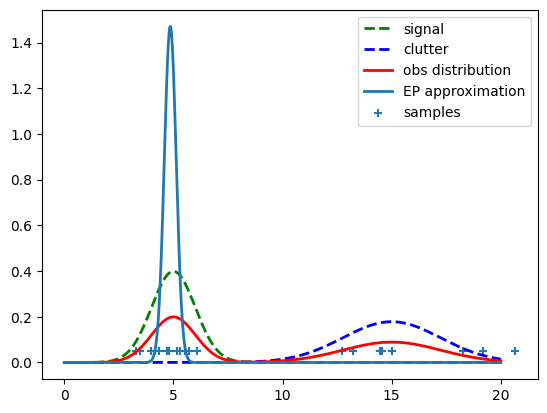

In [66]:
print(f'EP approximation posterior mean: {post_mean:.4f}')
print(f'EP approximation posterior variance: {post_var:.4f}')

def appx(x):
    return norm.pdf(x, loc=post_mean, scale=np.sqrt(post_var))

plot_clutter(ys, theta, theta_var, c_mean, c_var, c_prop=0.5, appx={'EP': appx}, graph_offset=5)